AI Jump-up 교육은 실습위주 교육이라고 들어서 실습을 중간중간 실습할 수 있도록
강의를 준비하게 되었고, 그래서 발표자료와 실습을 왔다갔다하는 문제를 방지하기 위해
MD로 자료를 만들게 되었습니다.

# Deep Learning for Computer Vision
***

## Plan for this lecture
1. ~~Deep Learning for~~ **Computer Vision**
2. **Deep Learning** ~~for Computer Vision~~
3. **Deep Learning for Computer Vision**

***

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import pandas as pd
import seaborn as sns
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
import matplotlib.pyplot as plt
from IPython.display import HTML

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class Resnet(nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

def plot_loss_variation(result, **kwargs):

    '''
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    '''
    list_data = []
    for epoch, train_loss in enumerate(result['train_losses']):
        list_data.append({'type': 'train', 'loss': train_loss, 'epoch': epoch})
    for epoch, val_loss in enumerate(result['val_losses']):
        list_data.append({'type': 'val', 'loss': val_loss, 'epoch': epoch})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89)


def plot_acc_variation(result, **kwargs):
    list_data = []
    for epoch, train_acc in enumerate(result['train_accs']):
        list_data.append({'type': 'train', 'Acc': train_acc, 'test_acc': result['test_acc'], 'epoch': epoch})
    for epoch, val_acc in enumerate(result['val_accs']):
        list_data.append({'type': 'val', 'Acc': val_acc, 'test_acc': result['test_acc'], 'epoch': epoch})


    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric, horizontalalignment='left', verticalalignment='center',
                 transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))

    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'],
                                              batch_size=args.train_batch_size,
                                              shuffle=True, num_workers=0)
    net.train()
    optimizer.zero_grad()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc


def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'],
                                            batch_size=args.test_batch_size,
                                            shuffle=False, num_workers=0)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc


def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'],
                                             batch_size=args.test_batch_size,
                                             shuffle=False, num_workers=0)
    net.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc


def experiment(partition, args):
    if args.model == 'CNN':
        net = CNN()
    elif args.model == 'Resnet':
        net = Resnet()
    else:
        raise ValueError('In-valid model choice')
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(
            'Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch,
                                                                                                                  train_acc,
                                                                                                                  val_acc,
                                                                                                                  train_loss,
                                                                                                                  val_loss,
                                                                                                                  te - ts))

    test_acc = test(net, partition, args)

    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

print('ready.')

Files already downloaded and verified
Files already downloaded and verified
ready.


## 1. ~~Deep Learning for~~ Computer Vision
### 1.1  Computer Vision is Everywhere!
![pt](https://github.com/karaopea/cnn/blob/master/images/498_FA2019_lecture01.pdf_page_09.jpg?raw=true
> 498_FA2019_lecture01
***

## 2. **Deep Learning** ~~for Computer Vision~~
### 2.1  Recap:Deep Learning
![pt](https://github.com/karaopea/cnn/blob/master/images/498_FA2019_lecture01.pdf_page_09.jpg?raw=true

    이번 섹션에서 딥러닝의 핵심적인 내용들을 되짚고 CNN을 진행하겠습니다.
***

#### 2.1.1  Real neuron
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide2.PNG?raw=true)

    이 그림은 모든 Neural Network을 얘기할때 꼭 나오는 뉴런 그림이죠? 지겨운 분들도 있을 것 같습니다.
    생물학적 백그라운드를 조금 알고 가면 좋을 것 같아 다시 준비 했습니다.
    키워드는,
    Dendrite에서 다른 뉴런들의 신호를 받아 Soma에서 상태값을 이용하여 매우 간단한 연산을하고 Axon을 통해
    다른 뉴런들에게 전달할지 말지 결정합니다. NN은 이런 인간의 뇌 구조를 모방하여 만들었습니다.
    (보신 우리 뇌에는 860억개의 뉴런이 있다고합니다.)
***

#### 2.1.1  Real neuron
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide90.PNG?raw=true)

    이 뉴런을 단순화해서 표현을 할껀데, 요게 뭡니까? 소죠?
    이게 피카소의 작품인데요, 소에서 점점 단순화되다가 결국 이렇게 되버렸죠.
    뿔은 무슨 더듬이처럼 됬고, 꼬리가 있네요, 다리도 네개고.
    그리고 몸통에.. 수컷이네요 수컷.


    자 그러면 뉴런은 어떻게 표현할까냐는건데, 엄청 간단합니다.
    소에서 저렇게 특징적인것만 표현했듯이
    뉴런도 다른 뉴런들에게서 받아 출력을 내는 그림으로 간단히 표현할 수 있습니다.
    이게 여러개 있으면 인공신경망, 뉴럴네트워크다 이렇게 말할 수 있습니다.

***

#### 2.1.2  Artificial neuron
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide3.PNG?raw=true)

    요 뉴런을 조금 더 자세히 표현하자면 그림과 같습니다.
    인공신경망의 뉴런 구조는 상태를 저장할 수 있는 weight ,bias 값을 이용하여
    input을 다음 뉴런에게 전달할지 결정하는 구조로 만들어져 있습니다.
    오해하지말아야 할 것은 뇌구조와 같게 만들었다는 뜻은 아니며,
    신경생리학적 관찰적인 부분을 모델링한 것으로 이해해주심 되겠습니다.
***

#### 2.1.2  Artificial neuron
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide4.PNG?raw=true)

    위 그래프를 보면서 설명드리자면, 파란,붉은점들은 input이라 볼 수 있으며,
    점선으로 표시된 부분의 뉴런의 weight를 표현하고 있습니다.
    다양한 점선들은 weight에 따라 input을 어떻게 프로젝션 할 수 있는 지 보여주고 있습니다.

    그럼 이제 파란점과 붉은점을 나누는 간단한 인공신경망을 만들어 보겠습니다
***
    

0 0.8787848949432373
1000 0.003038016613572836
2000 0.001510934205725789
3000 0.0010051975259557366
4000 0.0007530620787292719
5000 0.0006020592409186065
6000 0.0005014445632696152
7000 0.00042970303911715746
8000 0.00037585594691336155
9000 0.0003340268158353865
10000 0.00030057679396122694


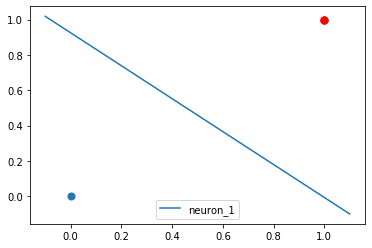

In [2]:
# for reproducibility
torch.manual_seed(777)

# input
X = torch.FloatTensor([[0, 0], [1, 1]])
Y = torch.FloatTensor([[0],[1]])

# nn layers
input_layer = torch.nn.Linear(2, 1, bias=True)
sigmoid = torch.nn.Sigmoid()

# model
model = torch.nn.Sequential(input_layer, sigmoid)

# define cost/loss & optimizer
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1)  # modified learning rate from 0.1 to 1

for step in range(10001):
    optimizer.zero_grad()
    hypothesis = model(X)

    # cost/loss function
    cost = criterion(hypothesis, Y)
    cost.backward()
    optimizer.step()

    if step % 1000 == 0:
        print(step, cost.item())

# for drawing
model_params = list(model.parameters())
model_weights = model_params[0].data.numpy()
model_bias = model_params[1].data.numpy()

plt.scatter(X.numpy()[[0,-1], 0], X.numpy()[[0, -1], 1], s=50)
plt.scatter(X.numpy()[[1,-1], 0], X.numpy()[[1, -1], 1], c='red', s=50)

x_1 = np.arange(-0.1, 1.1, 0.1)
y_1 = ((x_1 * model_weights[0,0]) + model_bias[0]) / (-model_weights[0,1])
plt.plot(x_1, y_1)

plt.legend(["neuron_1"], loc=8)
plt.show()

#### 2.1.3 Limitations
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide6.PNG?raw=true)

    이러한 방법론으로 인공신경망이 환대를 받고 있을때, xor problem이라는 심각한 문제가 등장합니다.
    선을 아무리 잘 그어도 위와같은 문제는 해결할 수 없었습니다.


    코드를 살펴보자면,
***

0 0.7273974418640137
1000 0.6931471824645996
2000 0.6931471824645996
3000 0.6931471824645996
4000 0.6931471824645996
5000 0.6931471824645996
6000 0.6931471824645996
7000 0.6931471824645996
8000 0.6931471824645996
9000 0.6931471824645996
10000 0.6931471824645996


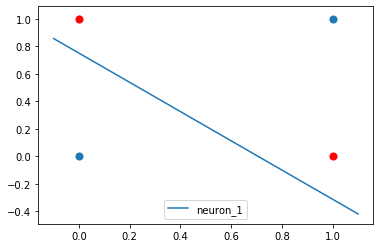

In [3]:
torch.manual_seed(777)

X = torch.FloatTensor([[0, 0], [0, 1], [1, 0], [1, 1]])
Y = torch.FloatTensor([[0], [1], [1], [0]])

input_layer = torch.nn.Linear(2, 1, bias=True)
sigmoid = torch.nn.Sigmoid()
model = torch.nn.Sequential(input_layer, sigmoid)

criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1)  # modified learning rate from 0.1 to 1

for step in range(10001):
    optimizer.zero_grad()
    hypothesis = model(X)

    cost = criterion(hypothesis, Y)
    cost.backward()
    optimizer.step()

    if step % 1000 == 0:
        print(step, cost.item())

model_params = list(model.parameters())
model_weights = model_params[0].data.numpy()
model_bias = model_params[1].data.numpy()

plt.scatter(X.numpy()[[0,-1], 0], X.numpy()[[0, -1], 1], s=50)
plt.scatter(X.numpy()[[1,2], 0], X.numpy()[[1, 2], 1], c='red', s=50)

x_1 = np.arange(-0.1, 1.1, 0.1)
y_1 = ((x_1 * model_weights[0,0]) + model_bias[0]) / (-model_weights[0,1])
plt.plot(x_1, y_1)

plt.legend(["neuron_1"], loc=8)
plt.show()

#### 2.1.4  First AI Winter
![pt](https://github.com/karaopea/cnn/blob/master/images/ai_winter.png?raw=true)

    이러한 간단한 문제도 풀지 못한다면서 손가락 질과 함께 첫번째 AI 암흑기로 돌입하게 됩니다.
***

#### 2.1.4 XOR Problem
![pt](https://github.com/karaopea/cnn/blob/master/images/xor.png?raw=true)

    XOR은 a,b가 서로 다를때 1이고 같을 때 0을 표현하는 함수를 뜻합니다.
    보니까 직선 하나로는 분류를 할 수 없겠다고 생각해서, 직선이 더 있으면 될 것 같다는 생각을 하게 됩니다.
***

#### 2.1.5 Solving XOR Problem
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide11.PNG?raw=true)

    전에는 x1, x2 에서 바로 y로 전달해었는데, 이제는 중간에 뭐가 하나 생겼죠?
    이것을 히든레이어(은닉층)이라고 하고 Multi-layer Perceptron이 등장하게 됩니다.
    수식이 좀 어지러워 보이는데 하나만 따라가보죠.
    우선 앞에가 a, 뒤가 b입니다. 결과만 보자면 같을때는 0, 다를때는 1값이 잘 나오고 있네요.
    (맨 아랫줄 하나씩 설명)
    그럼 코드로 구현해볼까요?
***

0 0.7434073090553284
1000 0.6930999755859375
2000 0.6838314533233643
3000 0.01398373395204544
4000 0.005768375005573034
5000 0.0036007347516715527
6000 0.0026096487417817116
7000 0.00204361486248672
8000 0.001678097527474165
9000 0.0014228165382519364
10000 0.0012345188297331333


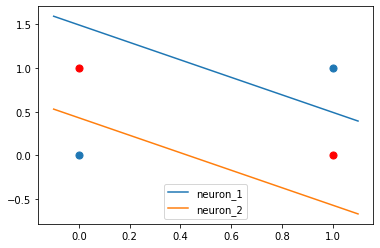

In [4]:
# for reproducibility
torch.manual_seed(777)

X = torch.FloatTensor([[0, 0], [0, 1], [1, 0], [1, 1]])
Y = torch.FloatTensor([[0], [1], [1], [0]])

# nn layers
input_layer = torch.nn.Linear(2, 2, bias=True)
hidden = torch.nn.Linear(2, 1, bias=True)
sigmoid = torch.nn.Sigmoid()

# model
model = torch.nn.Sequential(input_layer, sigmoid, hidden, sigmoid)

# define cost/loss & optimizer
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1)  # modified learning rate from 0.1 to 1

for step in range(10001):
    optimizer.zero_grad()
    hypothesis = model(X)

    # cost/loss function
    cost = criterion(hypothesis, Y)
    cost.backward()
    optimizer.step()

    if step % 1000 == 0:
        print(step, cost.item())

model_params = list(model.parameters())
model_weights = model_params[0].data.numpy()
model_bias = model_params[1].data.numpy()

plt.scatter(X.numpy()[[0,-1], 0], X.numpy()[[0, -1], 1], s=50)
plt.scatter(X.numpy()[[1,2], 0], X.numpy()[[1, 2], 1], c='red', s=50)

x_1 = np.arange(-0.1, 1.1, 0.1)
y_1 = ((x_1 * model_weights[0,0]) + model_bias[0]) / (-model_weights[0,1])
plt.plot(x_1, y_1)

x_2 = np.arange(-0.1, 1.1, 0.1)
y_2 = ((x_2 * model_weights[1,0]) + model_bias[1]) / (-model_weights[1,1])
plt.plot(x_2, y_2)

plt.legend(["neuron_1", "neuron_2"], loc=8)
plt.show()

    하나의 히든레이어를 추가함으로써 XOR문제를 해결하는 것을 볼 수 있습니다.

#### 2.1.4  Multi-layer Perceptron
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide13.PNG?raw=true)

    우리는 이러한 문제에 좀 더 직관적으로 이해할 필요가 있습니다.
    이해를 돕기위해 오른쪽 붉은점과 파란점을 색상을 좀 바꾸겠습니다.
***

#### 2.1.4  Multi-layer Perceptron
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide14.PNG?raw=true)

    뉴런이 어떠한 방향으로 프로젝션을 할 수 있다고 생각해보시면,
    프로젝션은 그위치에 어느 한 방향으로 본다고 생각하시면 편합니다.
    오른쪽위에서 왼쪽아래로 프로젝션하는 뉴런에게 보이는 모습은 오른쪽과 같을 겁니다.
    보라색은 왼쪽에 있고, 초록과 빨강은 겹쳐보일테고, 파랑은 오른쪽에 있겠죠
    다른 뉴런은 아래와 왼쪽과 같이 보일겁니다.
***

#### 2.1.4  Multi-layer Perceptron
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide15.PNG?raw=true)

    sigmoid함수를 지나면 0~1 사이에 값들로 치환이 될겁니다.
    0과 0이하의 값들은 0에 가깝게 모일테고 4를 넘는값들은 1에 가깝게 모이겠죠?
***

#### 2.1.4  Multi-layer Perceptron
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide16.PNG?raw=true)

    그럼 output 뉴런에 관점에서 오른쪽아래에서 왼쪽위로 다시 프로젝트를 해보면
    초록과빨강은 모이게되고, 파랑과 보라가 모이게 될 겁니다.
***

#### 2.1.4  Multi-layer Perceptron
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide17.PNG?raw=true)
[Multi-layer Perceptron](https://playground.tensorflow.org)

    0.5의 값으로 나누게 되면, 빨강과 파랑을 분류할 수 있습니다.
    이렇게 Neural Network의 layer들을 한층 씩 통과하면서 고차원적인 차원으로 이동하여,
    xor문제를 해결할 수 있게 된다는 것을 직관적으로 이해할 수 있습니다.
***

#### 2.1.5  Stochastic Gradient Decent
![pt](https://github.com/karaopea/cnn/blob/master/images/sgd.png?raw=true)

    여기서 어떻게 이 많은 뉴런들의 파라미터 값들을 학습할 것인지 문제가 생깁니다.
    여기서 Gradient Decent(경사하강법)이라는 방법론이 등장합니다.
    개념적으로 되짚어 보자면,
    최종적으로 나온 loss를 역전파를 진행하면서 각각의 뉴런의 weight에 대해서 편미분을 하면
    gradient가 나오는데, gradient가 낮아지는 방향으로 스텝스텝이동하면 전체 loss가 줄게됩니다.
    앞에 Stochastic이 붙은 이유는 전체 데이터를 한번에 보지 않고,
    mini-batch, 즉 데이터를 몇개 단위로 쪼개서 학습을 진행하면서 확률적으로 이동하기에 이런 이름이 붙었습니다.
***

#### 2.1.5  Second AI Winter
![pt](https://github.com/karaopea/cnn/blob/master/images/ai_winter.png?raw=true)

    그럼에도 불구하고 두번째 AI 암흑기가 찾아오게 됩니다.
    그 원인은 Vanishing Gradient(기울기소실) & Overfitting(과적합) 문제입니다.
***

#### 2.1.6 Vanishing Gradient Problem
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide22.PNG?raw=true)

    Vanishing Gradient는 뉴럴 네트워크를 깊게 쌓다보니,
    역전파가 잘 되지 않아 앞에 레이어들이 업데이트가 안되는 상황입니다.
    문제는 sigmoid activation function을 보면 알 수 있습니다.
    역전파를 할때 sigmoid의 도함수는 최대 0.25이기 때문에, 역전파를 하면 할 수록
    값이 1/4씩 작아진다는 문제점이 있었습니다.
    이 문제를 해결하기 위해 등장한 것이 아래보이는 RRRRReLU입니다.
    Relu는 양수 일 때 y=x값이 되며,
    특히 역전파를 할때 Relu의 도함수는 x는 0보다 크면 1 같거나 작으면 0이라는 도함수를 가지기 때문에
    VG문제를 해결할 수 있었습니다.
    여기서 "아니 그러면, 0이하일때도 그냥 y=x형태로 만들어버리면 안되? 느낌 좋은데?"라는 생각이 드실 수도 있을텐데
    그렇게 되면 non-linear한 성질을 잃어버리기 때문에 함수표현에 제한이 생깁니다.
    그래서 ReLU의 장점은 non-linear한 성질을 가지면서도 VG문제를 해결했다고 생각하시면 됩니다.
***

#### 2.1.7 Dropout
![pt](https://github.com/karaopea/cnn/blob/master/images/drop_out.png?raw=true)

    또하나의 문제는 학습데이터를 외워버려서,
    학습데이터에만 잘 동작하고 새로운 데이터에는 이상한 결과를 내놓는 overfitting 문제가 있었는데,
    보시면 뉴런들을 학습도중 랜덤하게 끊어서 학습하여 variance를 줄임으로써
    overfitting을 방지하는 방법으로 해결하였습니다.
    variance가 커지면 과하게 함수를 표현할 수 있기 때문에, 이걸 좀 normalization 해준다고 생각하시면 됩니다.
***

#### 2.1.8 What is the DL?
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide25.PNG?raw=true)

    딥러닝의 대가증 한명이자 튜링 수상자인 얀 르쿤 교수님이 딥러닝에 대한 정의를
    Deep Learning 마지막 장표로 채워넣으면서 이것으로 Deep Learning 핵심 되짚기는 끝내고
    드디어 Deep Learning for Computer Vision에 대한 이야기를 시작할까 합니다.

    "딥러닝은 패러미터화된 모듈들을 구축하고, 기울기 기반의 최적화를 통해 데이터를 학습시키는 것이다. 그게 다다."

    (결국 이 이야기를 하려고 했는데 먼길을 돌아온 것 같습니다. 그럼 잠시 질문을 받고, 10분정도 쉬는시간을 갖겠습니다.)
***

  <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br />

## 3. **Deep Learning for Computer Vision**
![pt](https://github.com/karaopea/cnn/blob/master/images/498_FA2019_lecture01.pdf_page_10.png?raw=true)
### 3.1  Plan for this lecture
1. d
2. d
3. d


    이제 컴퓨터비젼에서 활용되는 딥러닝 기술들을 봅시다.
    컴퓨터 비젼에 활용되는 현재 딥러닝 핵심 네트워크는 Convolutional Nerual Network입니다.
    Covolutional Neural Network는 CNN, ConvNet이라고 대부분 줄여서 부르고 있습니다.
***

### 3.2 Introduction
![pt](https://github.com/karaopea/cnn/blob/master/images/lecture_1_feifei.pdf_page_06.png?raw=true)

    CNN의 등장은 컴퓨터비전의 다양한 부분에 영향을 줬습니다.
    객체검출.......VQA(시각적 질의응답)까지 전체적인 정확도 향상을 가져왔습니다.
***

### 3.2 What is Convolutional Neural Network?
#### 3.2.1 How human recognize an image?
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide27.PNG?raw=true)

    Deep Learning을 강의에서 뉴런이 등장하듯이, CNN강의에서는 대부분 이 그림을 보실 수 있는데요,
    과연 인간의 뇌가 MLP처럼 단순하게 동작할까? 좀 더 우리가 모르는 것이 있지 않을까?
    사람이 이미지를 어떻게 인식하는지 생물학적(biologic)으로 알아보기 시작합니다.
    그래서  저런 단순한 움직임을 보여주며, 고양이의 뇌를 관찰합니다.
    선이 움직인다든지, 원이 커진다든지 이런 단순한 움직임을 보여줬는데.
    이런 움직임에서는 이 뉴런들만 활성화되고, 이런 움직임에서는 이런 뉴런들만 활성화되는것을
    발견할 수 있었습니다.
    그래서 우리는 이미지를 볼때 이런 간단한 특징들을 담당하는 뉴런들이 있는게 아닐까 그렇게 생각을 하게 됩니다.
***

### 3.2 What is Convolutional Neural Network?
#### 3.2.1 How human recognize an image?
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide28.PNG?raw=true)

    그리고 더 연구를 해보니까, 이 뉴런들이 계층 구조를 이루고 있다는 것을 알게됬거든요?
    무작위하게 얽혀있는게 아니라, 시각세포와 연결되어 있는 이런 얕은(shallow)한 뉴런들이 있고
    그리고 뒤에 이런 딥한 뉴런들이 있었는데, 이런 뉴런들이 언제 활성화가 되는지 살펴보니까
    이런 얕은 얘들은 빛이 있냐 없냐, 어떻게 기울어져있냐 등 간단한 정보에 반응을하고
    깊어지면 깊어질수록 이 선이 움직이느냐, 선이 이어져있느냐 끝나느냐.
    깊어지면 깊어질수록 고차원적인 정보를 담당하는 것을 알아내게 됩니다.
    그럼 이것을 어떻게 수학적으로 모델링해서 NN으로 만들 수 있을까? 이걸 고민해볼 차례겠죠.
***

In [2]:

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/FwFduRA_L6Q" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

C:\Users\kkj\Anaconda3\lib\site-packages\IPython\core\display.py:694: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


    얀 르쿤 교수님 팀에서 lenet이라는 convolutional network를 발표합니다.
    hand-writting 문자를 성공적으로 인식하는 것을 보실 수 있습니다.
    convolution, pooling등을 이용하며 이미지를 어떻게 딥러닝에 학습시킬지 방법론을 정립합니다.
***

### 3.3 Convolutional Neural Network
#### 3.3.1 How can we feed images to a neural network?
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide31.PNG?raw=true)

    그렇다면 이미지를 어떻게 뉴럴넷에 넣을 수 있을까요?
    이런 이미지가 있다고 생각해봅시다.
    배경에 나무라는 객체가 있는 심플한 이미지 입니다.
***

### 3.3 Convolutional Neural Network
#### 3.3.1 How can we feed images to a neural network?
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide32.PNG?raw=true)

    이 이미지를 뉴럴넷에 입력으로 넣고 싶은데, 뉴럴넷은 입력으로 벡터를 받기 때문에
    이미지는 2디멘션 그리드의 픽셀들입니다.
***

### 3.3 Convolutional Neural Network
#### 3.3.1 How can we feed images to a neural network?
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide34.PNG?raw=true)

    이 뉴럴넷에 넣기 위해 이미지를 쭉펴서 벡터로 만듭니다.
    이제 이 쫙 핀 이미지를 뉴럴넷에 넣으면 되겠네요.
***

### 3.3 Convolutional Neural Network
#### 3.3.1 How can we feed images to a neural network?
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide35.PNG?raw=true)

    하지만 기대와는 다르게 이렇게 넣으면 안됩니다.
    첫번째 문제는 이미자안에서 나무가 조금만 이동하더라도 인풋에 대한 특징이 달라지게 되어
    전혀다른 결과물을 만들게 됩니다.
***

### 3.3 Convolutional Neural Network
#### 3.3.1 How can we feed images to a neural network?
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide36.PNG?raw=true)

    우리는 이 이미지안에서 객체가 어느위치에 있든 같은 객체라고 인식하길 원합니다.
    이것을 Translation invriance하다고 하며,
    의미있는 정보를 위치에 상관없이 추출하고 같은 결과를 출력하길 원합니다.
***

### 3.3 Convolutional Neural Network
#### 3.3.2 Convolution ≈  Cross-correlation
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide37.PNG?raw=true)

    여기서 이런 객체의 위치에 구애받지 않고, 지역적 특징을 잘 추출하기 위해서
    Convolution 연산을 사용합니다.
    이해를 돕기 위해서 이미지를 1차원으로 줄였다고 가정하고 설명하겠습니다.
    Convolution 연산의 수학적 의미는 왼쪽과 같고,
    쉽게 커널(필터)를 뒤집고 곱해서 더한다라고 생각하시면됩니다.
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide38.PNG?raw=true)
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide39.PNG?raw=true)
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide40.PNG?raw=true)
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide41.PNG?raw=true)

    인풋 시그널이 어디에 있든 result의 위치는 다르겠지만 같은 형태의 결과가 나올 것입니다.
    이렇게 convolution연산과 softmax를 통해서 Translation invriance한 결과를 만듭니다.
    실제 뉴럴넷에서는 커널을 뒤집는것이 중요하지 않기 때문에, 커널을 그냥 곱해주는
    cross-correlation연산을 하지만 개념적인 부분만 사용한 것이기 때문에 Convolution이라고 부릅니다.
***

### 3.3 Convolutional Neural Network
#### 3.3.2 Convolution operation
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide43.PNG?raw=true)

    그럼 다시 2차원 이미지로 돌아와봅시다.
    1차원때 설명한 것과 같은 방법으로 진행합니다.
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide44.PNG?raw=true)
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide45.PNG?raw=true)

    한칸씩 이동하면서 곱하고 더해서 값을 만들고, 오른쪽 끝에 도달하면 한칸 아래로 내려와서
    반복합니다. 이것을 이미지 끝까지 진행하면 오른쪽과 같은 2차원 결과가 만들어질 것입니다.
***

### 3.3 Convolutional Neural Network
#### 3.3.2 Convolution operation
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide46.PNG?raw=true)

    우리는 3x3의 슬라이딩 윈도우를 커널이라고 부르고,
    이 커널과 곱하고 합해져서 나온 값을 feature map이라고 부릅니다.
    그리고 이 feature map을 보시면
    왼쪽 위 한칸이 상위의 3x3의 정보가 들어온것이기 때문에,
    이 칸의 Receptive filed는 여기 3x3이다 라고 말합니다.

***

### 3.3 Convolutional Neural Network
#### 3.3.2 Convolution operation
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide47.PNG?raw=true)

    이 3x3 convolution unit들은 뉴럴넷의 뉴런과 같은 기능을 하고 있으며,
    weight와 bias값을 가지고 이미지에서 선, 색상등 다양한 feature를 잘 추출하기 위해 학습되어 집니다.

    그럼 이미지를 하나 불러서 convolution 연산을 실습해봅시다.
***

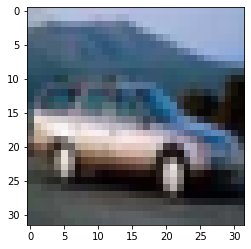

1.image shape: (32, 32, 3)
2.tensor shape: torch.Size([3, 32, 32])
3.shape of feature map after conv: torch.Size([3, 30, 30])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


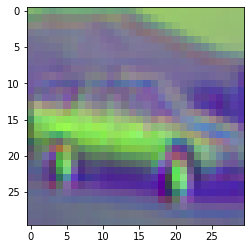

In [8]:
# select car image in cifar10 dataset
img = partition['train'].dataset.data[4]
plt.imshow(img)
plt.show()
print('1.image shape:',img.shape)

# trans np to torch (h,w,c) -> (c,h,w)
x = transform(img)
print('2.tensor shape:',x.shape)

conv = nn.Conv2d(3, 3, 3, stride=1)
# add batch dim
x = x.unsqueeze(0)
x = conv(x)
imshow(x.squeeze().detach().cpu())
print('3.shape of feature map after conv:',x.squeeze().shape)

### 3.3 Convolutional Neural Network
#### 3.3.2 Convolution operation
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide52.PNG?raw=true)

    방금 실습에서는 3개의 커널을 사용해서 convolution연산을 했습니다.
    커널이 많아질수록 각 필터가 예를들어 가로, 세로, 대각선 특징들을 뽑듯이
    다양한 feature들을 추출할 수 있습니다.
***

In [9]:
# select car image in cifar10 dataset
x = transform(img)
print(x.shape)

conv = nn.Conv2d(3, 3, 3, stride=1)
x = x.unsqueeze(0)
x = conv(x)
print(x.squeeze().shape)
x = conv(x)
print(x.squeeze().shape)
x = conv(x)
print(x.squeeze().shape)

torch.Size([3, 32, 32])
torch.Size([3, 30, 30])
torch.Size([3, 28, 28])
torch.Size([3, 26, 26])


### 3.3 Convolutional Neural Network
#### 3.3.2 Convolution operation
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide55.PNG?raw=true)

    위 코드 처럼 convolution연산은 convolution을 거듭할 수록 다음 feature맵이 작아지게 됩니다.
    입력 이미지가 작을 경우에는 convolution 연산을 몇번 할 수 없겠죠?
    마찬가지로 입력이 계속 작아지니 네트워크도 깊게 쌓을 수 없을 것 입니다.
***

### 3.3 Convolutional Neural Network
#### 3.3.3 Padding
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide57.PNG?raw=true)

    그래서 convolution 연산을 할 때, 테두리에 여분을 추가해서 입력이 축소되는 것을 방지합니다.
    이렇게 여분을 추가하는 것을 padding이라 부르고,
    input과 output크기가 같게 나오도록 conv하는 것을 same convolution이라고 부릅니다.
    3x3 커널일때는 한줄만 추가하면 되지만, 5x5 커널을 사용한다면 두줄을 추가해야 same conv가 되겠죠?
***

In [10]:
# select car image in cifar10 dataset
x = transform(img)
print(x.shape)

conv = nn.Conv2d(3, 3, 3, stride=1, padding=1)
x = x.unsqueeze(0)
x = conv(x)
print(x.squeeze().shape)
x = conv(x)
print(x.squeeze().shape)
x = conv(x)
print(x.squeeze().shape)

torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


### 3.3 Convolutional Neural Network
#### 3.3.4 Pooling
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide59.PNG?raw=true)

    반대로 입력 이미지가 너무 클 경우를 생각해봅시다.
    입력이 크다는 것은 유지해야할 parameter가 많아진다는 것을 뜻하는 것이고,
    이는 모델이 너무 커져 학습속도도 느려지고 같은 파라미터값들이 많아지는 현상이 일어날 수 있습니다.
    그래서 우리는 어느정도 이 feature map크기에서 특징추출을 한것 같다라는 생각이들면
    pooling을 통해서 입력을 줄여줍니다. 보통 계산하기 편하기 위해 입력을 반으로 줄입니다.
***

In [11]:
# select car image in cifar10 dataset
x = transform(img)
print(x.shape)

conv = nn.Conv2d(3, 3, 3, stride=1, padding=1)
x = x.unsqueeze(0)
x = conv(x)
print(x.squeeze().shape)
x = conv(x)
print(x.squeeze().shape)
x = conv(x)
print(x.squeeze().shape)

torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


### 3.3 Convolutional Neural Network
#### 3.3.5 Sequence of convolutional layers
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide61.PNG?raw=true)
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide63.PNG?raw=true)
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide64.PNG?raw=true)
    위와같이 CNN은 Convolution, Activation Fuction인 ReLU, Pooling등을 반복하면서 연산을 해나갑니다.
    첫번째 Convolution Kernel들은 색상이나 선의 방향등 단순한 feature들을 학습하고,
    Layer가 깊어질수록 더이상은 인간이 이해하지 못하는 고차원적인 feature들이 representation됩니다.RGB기 때문에..
    그래도 깊이 있는 애들이 복잡한 것을 탐지한다고 예상할 순 있겠네요.

    shallow한곳에서는 단순한 feature를 인식하고 deep한곳에서는 간단한 정보를 취합함으로써 좀 더 복잡한 정보를 탐지한다.
    이런식으로 뇌가 동작한다고 연구가 되어왔는데 그것을 잘 모방했다고 볼 수 있겠네요.

    이 그림은 언제 Layer5의 뉴런들이 Activation되는지 weight를 쌓아가면서 계산하여 Visulization을 한건데요,
    Layer 5까지오면 꽃잎의 형태, 사람얼굴, 강아지의 얼굴등 고차원적인 정보를 다루는 것을 볼 수 있습니다.
***

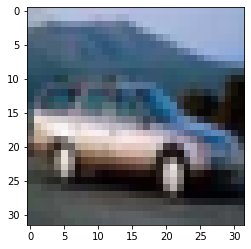

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


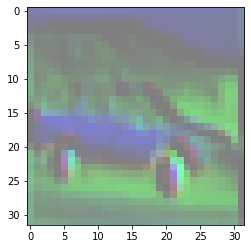

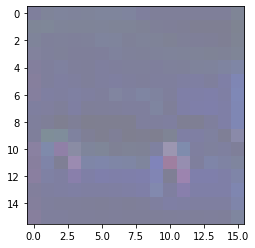

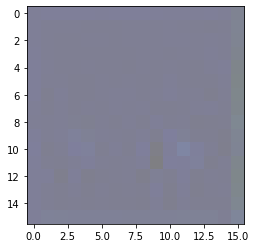

In [12]:
# select car image in cifar10 dataset
img = partition['train'].dataset.data[4]
plt.imshow(img)
plt.show()

# trans np to torch (h,w,c) -> (c,h,w)

x = transform(img)

conv = nn.Conv2d(3, 3, 3, stride=1, padding=1)
relu = nn.ReLU()
pooling = nn.MaxPool2d(2,2)
# add batch dim
x = x.unsqueeze(0)
x = relu(conv(x))
imshow(x.squeeze().detach().cpu())
x = pooling(relu(conv(x)))
imshow(x.squeeze().detach().cpu())
x = relu(conv(x))
imshow(x.squeeze().detach().cpu())

    실습을 간단히 해보자면, 여기서는 커널(필터)들이 어떻게 학습되어지는진 볼 순 없지만
    Conv연산을 거칠수록 feature맵이 어떻게 변화되는지 살펴보도록 합시다.
    위에 설명드린것처럼 Convoltion연산을 하고, Activation function을 통과하고 중간에 풀링을 해보겠습니다.

### 3.3 Convolutional Neural Network
#### 3.3.5 Sequence of convolutional layers
![pt](https://github.com/karaopea/cnn/blob/master/images/pt/Slide65.PNG?raw=true)

    이것은 Convolution Net의 기본 구조를 나타낸건데요. 한번 봅시다.
    아까 말씀드렸듯이, Conv, ReLU, Pool을 반복하고, 마지막에 FC가 있네요.
    FC는 MLP와 같은 말입니다. 마지막에 나온 고차원적인 정보를 vectorize 시켜서
    MLP에 넣어주고, 이게 어떤 객체인지 MLP와 했던것과 똑같이 분류문제를 풉니다.
    마지막 feature맵은 더이상 위치정보가 남아있지 않은 객체의 feature의 정보이기 때문에
    MLP로 넣을 수 있게 되는거구요.

    그럼 위와 그림과 같은 ConvNet을 하나 구현해볼까요?
***

Namespace(act='relu', epoch=5, exp_name='exp1_lr', l2=1e-05, lr=0.001, model='CNN', optim='SGD', test_batch_size=32, train_batch_size=128)
Epoch 0, Acc(train/val): 10.08/11.67, Loss(train/val) 2.30/2.30. Took 11.39 sec
Epoch 1, Acc(train/val): 16.73/23.98, Loss(train/val) 2.22/2.11. Took 10.26 sec
Epoch 2, Acc(train/val): 25.75/27.79, Loss(train/val) 2.00/1.91. Took 10.26 sec
Epoch 3, Acc(train/val): 32.38/37.68, Loss(train/val) 1.81/1.68. Took 10.21 sec
Epoch 4, Acc(train/val): 41.11/42.54, Loss(train/val) 1.59/1.55. Took 10.24 sec


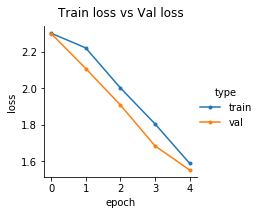

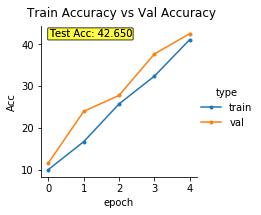

In [13]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1 )
        self.conv1_2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.conv2_1 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1 )
        self.conv2_2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv3_1 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        #32->16->8->4 : 4*4*64
        self.fc = nn.Linear(4*4*64, 10)

    def forward(self, x):
        x = self.relu(self.conv1_1(x))
        x = self.relu(self.conv1_2(x))
        x = self.pool(x)
        x = self.relu(self.conv2_1(x))
        x = self.relu(self.conv2_2(x))
        x = self.pool(x)
        x = self.relu(self.conv3_1(x))
        x = self.relu(self.conv3_2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr"
#models = ['CNN', 'Resnet']
args.model = 'CNN'
args.act = 'relu'
args.l2 = 0.00001
args.optim = 'SGD'  # 'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 1e-3
args.epoch = 50

args.train_batch_size = 128
args.test_batch_size = 32


print(args)
setting, result = experiment(partition, deepcopy(args))
#df = pd.DataFrame(result)
plot_loss_variation(result)
plot_acc_variation(result)